<a href="https://colab.research.google.com/github/jnrkufuor/apollo/blob/Ryan/Graph_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Required Packages



In [1]:
!pip install squarify

!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

import torch
import torch_geometric.utils as tgu

import re
import pandas as pd
import numpy as np
import math
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import statistics
from google.colab import drive
drive.mount('/content/drive')

import random

import pandas_datareader.data as web
from datetime import datetime

tqdm.pandas()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Running the Experiment for News and Financial Data

100%|██████████| 22/22 [00:00<00:00, 2924.16it/s]
0it [00:00, ?it/s]
100%|██████████| 61/61 [00:00<00:00, 4640.56it/s]
0it [00:00, ?it/s]
100%|██████████| 47/47 [00:00<00:00, 3187.83it/s]
0it [00:00, ?it/s]
100%|██████████| 17/17 [00:00<00:00, 2774.98it/s]
0it [00:00, ?it/s]
100%|██████████| 40/40 [00:00<00:00, 3344.01it/s]
0it [00:00, ?it/s]
100%|██████████| 29/29 [00:00<00:00, 3804.89it/s]
0it [00:00, ?it/s]
100%|██████████| 56/56 [00:00<00:00, 3505.53it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:00<00:00, 3515.66it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:00<00:00, 2820.04it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
100%|██████████| 67/67 [00:00<00:00, 4591.65it/s]


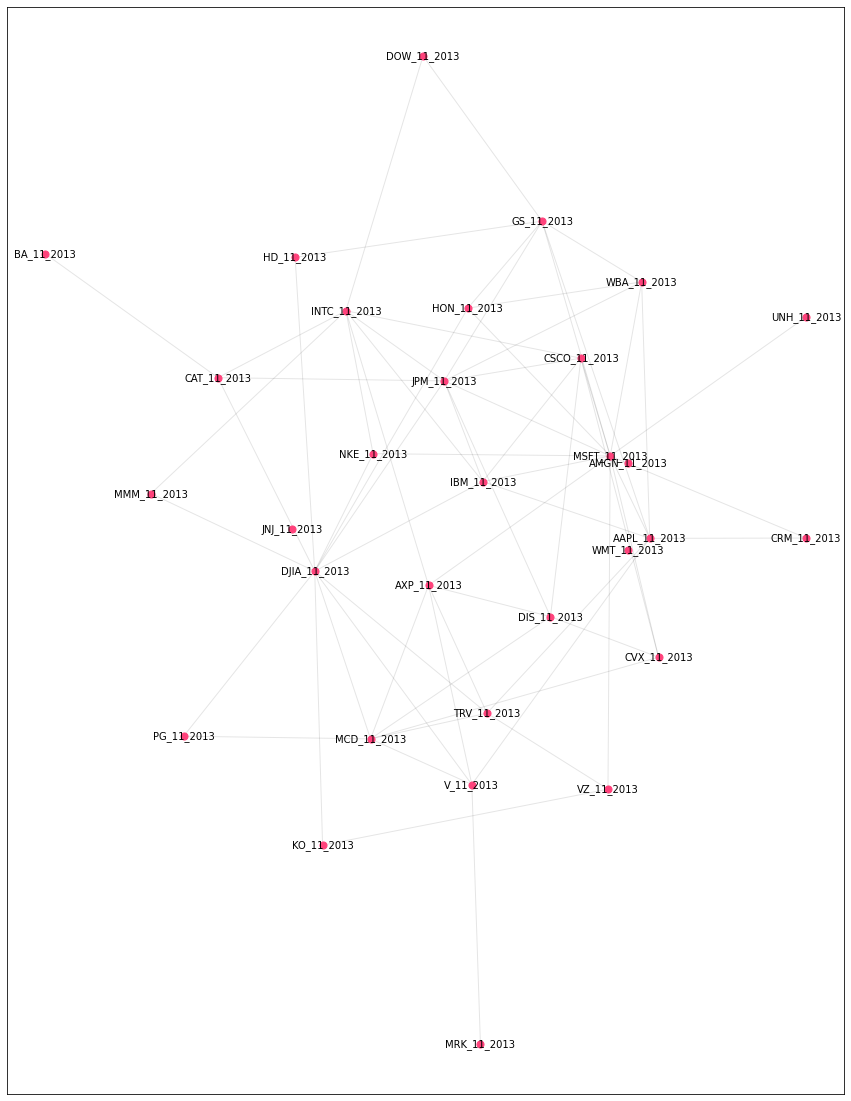

In [58]:
wiki  = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average#Components')
wiki_table  = wiki[1]
symbols = (wiki_table.Symbol.values.tolist()) + ['DJIA']
df = pd.DataFrame(symbols, columns=['Symbol'])
start_dates = pd.date_range(start='2011-01-01', end='2019-12-01', freq='MS')
end_dates = pd.date_range(start='2011-01-31', end='2019-12-31', freq='M')
news_graphs_vec=[]
price_graphs_vec=[]
comb1_graphs_vec=[]
comb2_graphs_vec=[]
comb3_graphs_vec=[]
comb4_graphs_vec=[]

pull_start = '2011-01-01'
pull_end  = '2019-12-31'
df = pd.DataFrame(symbols, columns=['Symbol'])
symbols = sorted(symbols)

for i, symbol in enumerate(symbols):
    try:
        df = web.DataReader(symbol,'yahoo', pull_start, pull_end)
        df = df[['Adj Close','Volume']]
        df.to_csv('/content/drive/My Drive/JPM_financial_data/' + "{}.csv".format(symbol))
    except KeyError:
      print("Error for {}".format(symbol))
      pass
#df_price[(df_price.index > '2011-03-31') & (df_price.index > '2011-05-30')]

index = pd.date_range(start=pull_start, end=pull_end, freq='D')     # initialize an empty DateTime Index
df_price = pd.DataFrame(index=index, columns=symbols)               # initialize empty dataframes
df_volume = pd.DataFrame(index=index, columns=symbols)

for symbol in symbols:
    symbol_df = pd.read_csv('/content/drive/My Drive/JPM_financial_data/' + symbol+".csv").set_index('Date')
    symbol_df.index = pd.to_datetime(symbol_df.index)

    df_price[symbol] = symbol_df['Adj Close']
    df_volume[symbol] = symbol_df['Volume']

df_price.dropna(how='all', inplace=True)
df_volume.dropna(how='all', inplace=True)
assert((df_price.index == df_volume.index).all())
df_price = df_price.bfill(axis='rows')   
df_price = df_price.ffill(axis='rows')

df_links=pd.read_csv('/content/drive/My Drive/df_links_2011_2019.csv')

new_dates=[]

for date in df_links['date']:
    reg_date=re.sub("^.*?([A-Z])", "\\1", date)
    temp_date=datetime.strptime(reg_date,"%b %d, %Y")
    new_dates.append(pd.to_datetime(datetime.strftime(temp_date, "%Y-%m-%d")))

df_links['date']=new_dates

for i in range(0, 35, 1):

  df_links_pres = df_links[(df_links['date'] >= start_dates[3*i]) & (df_links['date'] <= start_dates[3*i+2])]
  df_links_pres = df_links_pres.groupby(['from', 'to']).size().reset_index()
  df_links_pres.rename(columns={0: 'weight'}, inplace=True)
  df_links_pres.reset_index(drop=True, inplace=True)
  df_links_pres = df_links_pres[df_links_pres['weight'] > 1]

  df_price_pres = df_price[(df_price.index >= start_dates[3*i]) & (df_price.index <= end_dates[3*i+2])]
  df_price_next = df_price[(df_price.index >= start_dates[3*(i+1)]) & (df_price.index <= end_dates[3*(i+1)+2])]
  df_volume_pres = df_volume[(df_volume.index >= start_dates[3*i]) & (df_volume.index <= end_dates[3*i+2])]
  #code for one-month intervals below
  #df_volume_pres = df_volume[(df_volume.index >= start_dates[i]) & (df_volume.index <= end_dates[i])]
  #df_price_pres = df_price[(df_price.index >= start_dates[i]) & (df_price.index <= end_dates[i])]
  #df_price_next = df_price[(df_price.index >= start_dates[i+1]) & (df_price.index <= end_dates[i+1])]
  
  df_price_pct_pres = df_price_pres.pct_change().dropna(how='all')
  df_price_pct_next = df_price_next.pct_change().dropna(how='all')
  df_volume_pct_pres = df_volume_pres.pct_change().dropna(how='all')
  
  #added next period's info

  price_corr = df_price_pct_pres.corr()
  volume_corr = df_volume_pres.corr()

  df_finance_nds = pd.DataFrame(columns = ["from", "to", "weight"])
  price_corr.index = price_corr.columns
  #*******************
  volume_corr.index = volume_corr.columns

  # Get correlation pairs for Price and Volume
  df_corr_price = price_corr[abs(price_corr) >= 0.000001].stack().reset_index()
  df_corr_vol = volume_corr[abs(volume_corr) >= 0.000001].stack().reset_index()

  #Take out lower triangle 
  #for price
  df_corr_price  = df_corr_price[df_corr_price['level_0'].astype(str)!=df_corr_price['level_1'].astype(str)]
  df_corr_price['ordered-cols'] = df_corr_price.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)

  #for volume
  df_corr_vol  = df_corr_vol[df_corr_vol['level_0'].astype(str)!=df_corr_vol['level_1'].astype(str)]
  df_corr_vol['ordered-cols'] = df_corr_vol.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)

  #Remove duplicates and exclude self-correlated values
  #for price
  df_corr_price = df_corr_price.drop_duplicates(['ordered-cols'])
  df_corr_price.reset_index(drop=True, inplace=True)
  df_corr_price.drop(['ordered-cols'], axis=1, inplace=True)


  #for volume
  df_corr_vol = df_corr_vol.drop_duplicates(['ordered-cols'])
  df_corr_vol.reset_index(drop=True, inplace=True)
  df_corr_vol.drop(['ordered-cols'], axis=1, inplace=True)

  #rename columns
  df_corr_price.columns = ["from","to","correlation"]
  df_corr_vol.columns = ["from","to","correlation"]

  pcorr_mins[i]=df_corr_price['correlation'].min()
  vcorr_mins[i]=df_corr_vol['correlation'].min()

  unique_nodes=[]
  for colname in df_price.columns:
      if colname not in unique_nodes: 
        unique_nodes.append(colname)
      else:
        continue

  df_news_nodes=df_finance_nds

  for j in range(0,len(df_corr_price)):
      if(abs(df_corr_price["correlation"][j]) > 0.6 or abs(df_corr_vol["correlation"][j]) > 0.6):
        df_finance_nds= df_finance_nds.append({"from" : df_corr_vol["from"][j], "to" : df_corr_vol["to"][j], "weight" : ((abs(df_corr_price["correlation"][j])+abs(df_corr_price["correlation"][j]))/2)},ignore_index=True)
      elif (abs(df_corr_price["correlation"][j]) < 0.6 and abs(df_corr_vol["correlation"][j]) < 0.6):
          if (abs(df_corr_price["correlation"][j]) >= 0.4 and abs(df_corr_vol["correlation"][j]) >= 0.4):
              df_finance_nds = df_finance_nds.append({"from" : df_corr_vol["from"][j], "to" : df_corr_vol["to"][j], "weight" : ((abs(df_corr_price["correlation"][j])+abs(df_corr_price["correlation"][j]))/2)},ignore_index=True)
  #should consider making these edges directed if we have time
  #negative correlation is VERY different than positive correlation for our predictions
  #Update: I've investigated this and we don't have any edges drawn for negative correlations
  #Ideally this should be fixed going forward but right now it isn't affecting modeling

  #for finance*****
  df_plot_fin = df_finance_nds
  df_plot_fin.reset_index(inplace=True, drop=True)

  df_plot_news = df_links_pres
  df_plot_news.reset_index(inplace=True, drop=True)


  df_plot_comb1=df_finance_nds[['from','to']].append(df_links_pres[['from','to']])
  df_plot_comb1.reset_index(inplace=True, drop=True)

  df_plot_comb2=(df_finance_nds[['from','to']].sample(n = int(0.5*round(len(df_finance_nds['from']))))).append(
      df_links_pres[['from','to']].sample(n = int(0.5*round(len(df_links_pres['from']))))
  )
  df_plot_comb2.reset_index(inplace=True, drop=True)

  df_plot_comb3=df_links_pres[['from','to']].merge(df_finance_nds[['from','to']], how='inner', on=['from', 'to'])
  df_plot_comb3.reset_index(inplace=True, drop=True)


  df_plot_comb4=df_plot_comb3[['from','to']]
  dfpc4_tempf = df_finance_nds[['from','to']].merge(df_links_pres[['from','to']], how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
  dfpc4_tempn = df_links_pres[['from','to']].merge(df_finance_nds[['from','to']], how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
  dfpc4_tempb = dfpc4_tempf[['from','to']].append(dfpc4_tempn[['from','to']])
  df_plot_comb4 = df_plot_comb4.append(dfpc4_tempb.sample(n = int(0.5*round(len(dfpc4_tempb['from'])))))
  df_plot_comb4.reset_index(inplace=True, drop=True)

  df_plots = [df_plot_fin, df_plot_news, df_plot_comb1, df_plot_comb2, df_plot_comb3, df_plot_comb4]
  #Build Graph Variables

  gr_price = nx.Graph() #financial graph
  gr_news = nx.Graph()
  gr_comb1 = nx.Graph() #creating 3 attempts at a combined-edge graph
  gr_comb2 = nx.Graph()
  gr_comb3 = nx.Graph()
  gr_comb4 = nx.Graph()
  graph = [gr_price,gr_news,gr_comb1,gr_comb2,gr_comb3, gr_comb4]
  #add edges and nodes to graph

  #add nodes

  for nd in unique_nodes:
     for g in graph:
       g.add_node(nd)

  for plot_num in range(0,6,1):
    for link in tqdm(df_plots[plot_num].index):
        graph[plot_num].add_edge(df_plots[plot_num].iloc[link]['from'],
                  df_plots[plot_num].iloc[link]['to'])
                 #weight=df_plots[plot_num].iloc[link]['weight'])
                 #commented because we aren't using the weights and weights become trickier (but probably still doable) with combined graphs
    #**    

  node_labels = {} 
  nodes_multi_layer={}
  node_type=["t1","t2"]
  type_count=0


  month_pct_chg=df_price_next.mean(axis=0) - df_price_pres.mean(axis=0)
  month_chg_label=pd.Series(np.zeros(len(month_pct_chg)))
  for index in range(0, len(month_pct_chg),1):
    if month_pct_chg[index] > 0:
      month_chg_label[index]=1
    else:
      month_chg_label[index]=0

  month_chg_label.index=month_pct_chg.index
  for g in graph:
    nx.set_node_attributes(g, month_chg_label, name='y')
    nx.set_node_attributes(g, df_price_pct_pres.iloc[0:57], name='x')
  #chosen y- percent change in 3-month avg from 1 period to next, 1 is increase 2 is decrease
  #index on df_price_pct_pres added here because Dataloader appears to need homogeneous length 
  #ideally would be bfilled to equal length of 63 but that's a potential task
  for g_ind in range(0,len(graph),1):
    graph[g_ind]=nx.relabel.relabel_nodes(graph[g_ind], lambda x: x + str('_') + str(start_dates[i])[5:7] + str('_') + str(start_dates[i])[0:4])
    
  #above line separates nodes from different years
  price_graphs_vec.append(graph[0])
  news_graphs_vec.append(graph[1])
  comb1_graphs_vec.append(graph[2])
  comb2_graphs_vec.append(graph[3])
  comb3_graphs_vec.append(graph[4])
  comb4_graphs_vec.append(graph[5])



#createdictionary of nodes and labels
node_count =0
for node in comb4_graphs_vec[34].nodes():
    #set the node name as the key and the label as its value 
    node_labels[node] = node

    node_count+=1

pos = nx.kamada_kawai_layout(comb4_graphs_vec[34])
fig, axs = plt.subplots(1, 1, figsize=(15,20))

el = nx.draw_networkx_edges(comb4_graphs_vec[34], pos, alpha=0.1, ax=axs)
nl = nx.draw_networkx_nodes(comb4_graphs_vec[34], pos, nodelist=comb4_graphs_vec[34].nodes, node_color='#FF427b', 
                            node_size=50, ax=axs)
ll = nx.draw_networkx_labels(comb4_graphs_vec[34], pos, font_size=10, font_family='sans-serif')

[-0.10199373225992119,
 -0.14868209233660654,
 0.3671492756997816,
 0.16536787541239628,
 -0.13304939405907631,
 -0.057567044341030604,
 -0.22938723635036665,
 -0.004661407389908084,
 -0.2324976721098732,
 -0.06622850694390295,
 -0.2983824471215648,
 -0.1547717756398892,
 -0.09311619869421334,
 -0.20435195313578366,
 -0.2094112223320404,
 -0.07102953428012052,
 -0.061487429780078845,
 -0.10692410130022875,
 0.31613883234523066,
 -0.05899386139032734,
 -0.04729659035035911,
 -0.08542414563914705,
 -0.2594204030565171,
 -0.3573979316528732,
 -0.2567188209985204,
 -0.2681783054197886,
 -0.37664281731075744,
 -0.46898795764727774,
 0.23681971960193496,
 -0.07205192573420138,
 -0.26346745259961113,
 -0.029684971977587123,
 -0.20588707587756946,
 -0.39456381803908724,
 -0.09219110610774367]

# Building GCN for Node Attribute Prediction

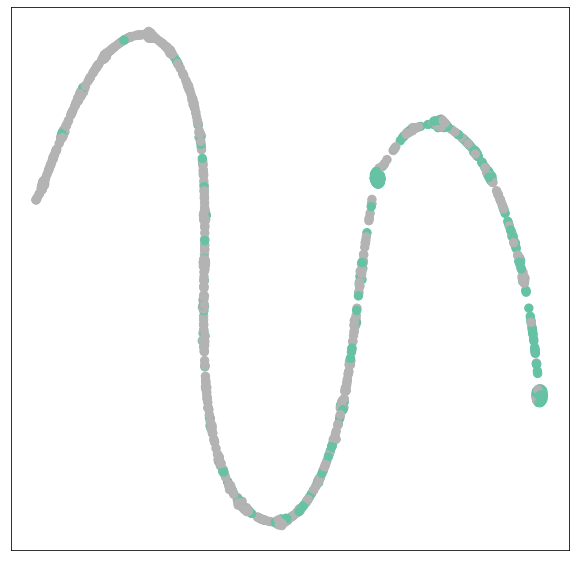

tensor([0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 1., 1., 

In [47]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
import torch_geometric.data as tgd

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

class GCN_Mult(torch.nn.Module):
    def __init__(self, hidden_channels, num_feats):
        super(GCN_Mult, self).__init__()
        torch.manual_seed(12345)
        num_labels=2
        self.conv1 = GCNConv(num_feats, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_labels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


nx_gvec=[news_graphs_vec, price_graphs_vec, comb1_graphs_vec, comb2_graphs_vec, comb3_graphs_vec, comb4_graphs_vec]

pyt_vec=[None]*len(nx_gvec)
train_vec=[None]*len(nx_gvec)
test_vec=[None]*len(nx_gvec)
#out_vec=[None]*len(nx_gvec)
for gtype_index in range(0, len(nx_gvec), 1):
  pyt_vec[gtype_index]=list(map(tgu.from_networkx, nx_gvec[gtype_index]))
  train_vec[gtype_index]=tgd.Batch.from_data_list(pyt_vec[gtype_index][0:28])
  test_vec[gtype_index]=tgd.Batch.from_data_list(pyt_vec[gtype_index][28:35])
  #model = GCN_Mult(hidden_channels=16, num_feats=train_vec[gtype_index].num_features).double()
  #out_vec[gtype_index]=model(train_vec[gtype_index].x.double(), train_vec[gtype_index].edge_index)

#Experimental diff- we don't have 2020 data, need to either pull it (possible) or discard
#should use 2019/2020 as validation, likely for hyper parameters
#I am not sure I will be able to run find the best parameters via a hyperloop given the time we have
#fix classifier to be average price in next 3-month period

out = model(train_vec[0].x.double(), train_vec[0].edge_index)
visualize(out[0], color=train_vec[0].y)
train_vec[0].y

# Training the Model and Testing Accuracy

In [48]:
from IPython.display import Javascript  # Restrict height of output cell.
from sklearn.model_selection import ShuffleSplit
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

test_acc_vec=['None']*len(pyt_vec)

for gvec_ind in range(0,len(pyt_vec),1):

  model = GCN_Mult(hidden_channels=16,num_feats=train_vec[gvec_ind].num_features).double()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
  criterion = torch.nn.CrossEntropyLoss()
  #smoothL1 loss if we go to regression loss. investigate other losses for classification
  #potential sigmoid layer as well

  def train():
        model.train()
        optimizer.zero_grad()  # Clear gradients.
        out = model(train_vec[gvec_ind].x.double(), train_vec[gvec_ind].edge_index)  # Perform a single forward pass.
        loss = criterion(out, train_vec[gvec_ind].y.long())  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        return loss

  def test():
        model.eval()
        out = model(test_vec[gvec_ind].x.double(), test_vec[gvec_ind].edge_index).double()
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        test_correct = pred == test_vec[gvec_ind].y.double()  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / len(test_vec[gvec_ind].y)  # Derive ratio of correct predictions.
        return test_acc

  for epoch in range(1, 201):
      loss = train()
      #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

  test_acc = test()
  test_acc_vec[gvec_ind]=test_acc
  print(f'Test Accuracy: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Test Accuracy: 0.6590
Test Accuracy: 0.6544
Test Accuracy: 0.6682
Test Accuracy: 0.6636
Test Accuracy: 0.6498
Test Accuracy: 0.6636


In [38]:
test_acc_vec
#sum(test_vec[3].y)/len(test_vec[3].y)
#benchmark is 65.44% currently

[0.6589861751152074,
 0.6543778801843319,
 0.6682027649769585,
 0.663594470046083,
 0.6497695852534562,
 0.6589861751152074]

# Running Experiment for Financial Data

100%|██████████| 131/131 [00:00<00:00, 2305.40it/s]


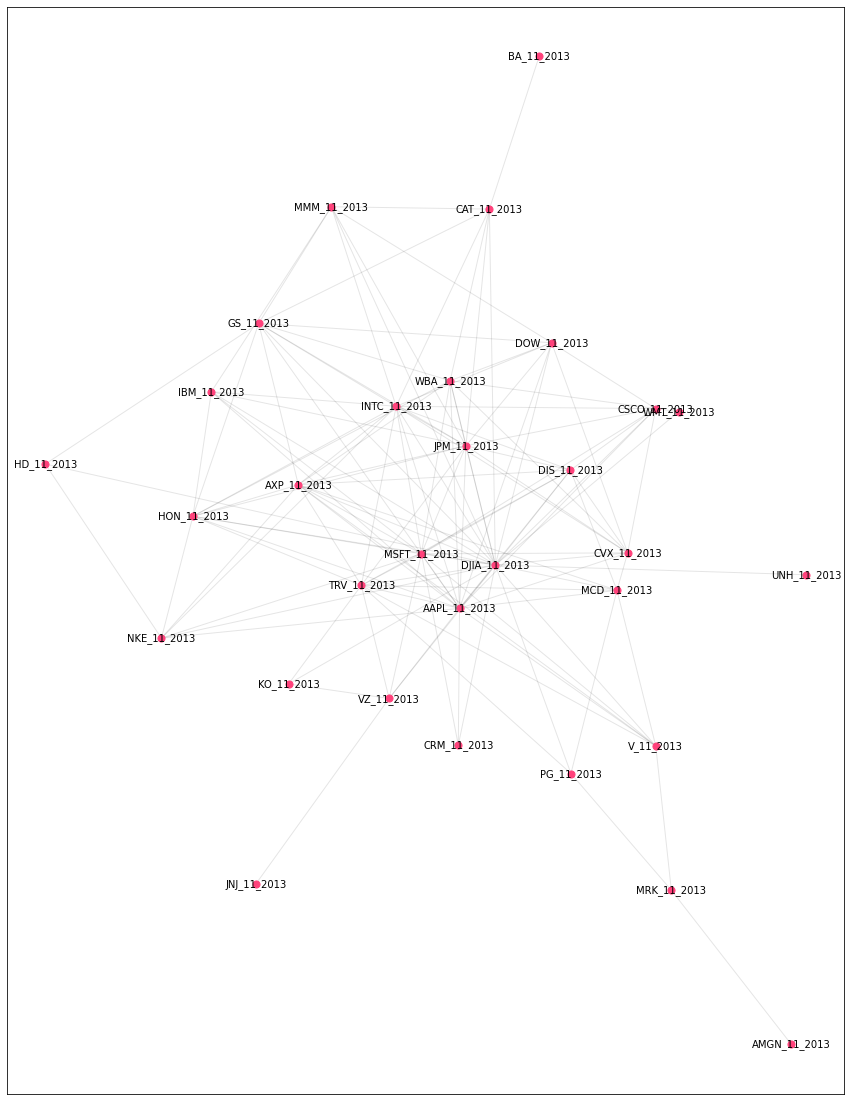

In [3]:
# wiki  = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average#Components')
# wiki_table  = wiki[1]
# symbols = (wiki_table.Symbol.values.tolist()) + ['DJIA']
# df = pd.DataFrame(symbols, columns=['Symbol'])
# start_dates = pd.date_range(start='2011-01-01', end='2019-12-01', freq='MS')
# end_dates = pd.date_range(start='2011-01-31', end='2019-12-31', freq='M')
# graphs_vec=[]

# pull_start = '2011-01-01'
# pull_end  = '2019-12-31'
# df = pd.DataFrame(symbols, columns=['Symbol'])
# symbols = sorted(symbols)

# for i, symbol in enumerate(symbols):
#     try:
#         df = web.DataReader(symbol,'yahoo', pull_start, pull_end)
#         df = df[['Adj Close','Volume']]
#         df.to_csv('/content/drive/My Drive/JPM_financial_data/' + "{}.csv".format(symbol))
#     except KeyError:
#       print("Error for {}".format(symbol))
#       pass
# #df_price[(df_price.index > '2011-03-31') & (df_price.index > '2011-05-30')]

# index = pd.date_range(start=pull_start, end=pull_end, freq='D')     # initialize an empty DateTime Index
# df_price = pd.DataFrame(index=index, columns=symbols)               # initialize empty dataframes
# df_volume = pd.DataFrame(index=index, columns=symbols)

# for symbol in symbols:
#     symbol_df = pd.read_csv('/content/drive/My Drive/JPM_financial_data/' + symbol+".csv").set_index('Date')
#     symbol_df.index = pd.to_datetime(symbol_df.index)

#     df_price[symbol] = symbol_df['Adj Close']
#     df_volume[symbol] = symbol_df['Volume']

# df_price.dropna(how='all', inplace=True)
# df_volume.dropna(how='all', inplace=True)
# assert((df_price.index == df_volume.index).all())
# df_price = df_price.bfill(axis='rows')   
# df_price = df_price.ffill(axis='rows')

# for i in range(0, 35, 1):

#   df_price_pres = df_price[(df_price.index >= start_dates[3*i]) & (df_price.index <= end_dates[3*i+2])]
#   df_price_next = df_price[(df_price.index >= start_dates[3*(i+1)]) & (df_price.index <= end_dates[3*(i+1)+2])]
#   df_volume_pres = df_volume[(df_volume.index >= start_dates[3*i]) & (df_volume.index <= end_dates[3*i+2])]
#   #code for one-month intervals below
#   #df_volume_pres = df_volume[(df_volume.index >= start_dates[i]) & (df_volume.index <= end_dates[i])]
#   #df_price_pres = df_price[(df_price.index >= start_dates[i]) & (df_price.index <= end_dates[i])]
#   #df_price_next = df_price[(df_price.index >= start_dates[i+1]) & (df_price.index <= end_dates[i+1])]
  
#   df_price_pct_pres = df_price_pres.pct_change().dropna(how='all')
#   df_price_pct_next = df_price_next.pct_change().dropna(how='all')
#   df_volume_pct_pres = df_volume_pres.pct_change().dropna(how='all')
#   #added next period's info

#   price_corr = df_price_pct_pres.corr()
#   volume_corr = df_volume_pres.corr()

#   df_finance_nds = pd.DataFrame(columns = ["from", "to", "weight"])
#   price_corr.index = price_corr.columns
#   #*******************
#   volume_corr.index = volume_corr.columns

#   # Get correlation pairs for Price and Volume
#   df_corr_price = price_corr[abs(price_corr) >= 0.000001].stack().reset_index()
#   df_corr_vol = volume_corr[abs(volume_corr) >= 0.000001].stack().reset_index()

#   #Take out lower triangle 
#   #for price
#   df_corr_price  = df_corr_price[df_corr_price['level_0'].astype(str)!=df_corr_price['level_1'].astype(str)]
#   df_corr_price['ordered-cols'] = df_corr_price.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)

#   #for volume
#   df_corr_vol  = df_corr_vol[df_corr_vol['level_0'].astype(str)!=df_corr_vol['level_1'].astype(str)]
#   df_corr_vol['ordered-cols'] = df_corr_vol.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)

#   #Remove duplicates and exclude self-correlated values
#   #for price
#   df_corr_price = df_corr_price.drop_duplicates(['ordered-cols'])
#   df_corr_price.reset_index(drop=True, inplace=True)
#   df_corr_price.drop(['ordered-cols'], axis=1, inplace=True)

#   #for volume
#   df_corr_vol = df_corr_vol.drop_duplicates(['ordered-cols'])
#   df_corr_vol.reset_index(drop=True, inplace=True)
#   df_corr_vol.drop(['ordered-cols'], axis=1, inplace=True)

#   #rename columns
#   df_corr_price.columns = ["from","to","correlation"]
#   df_corr_vol.columns = ["from","to","correlation"]

#   unique_nodes=[]
#   for colname in df_price.columns:
#       if colname not in unique_nodes: 
#         unique_nodes.append(colname)
#       else:
#         continue

#   for j in range(1,len(df_corr_price)):
#       if(abs(df_corr_price["correlation"][j]) > 0.6 or abs(df_corr_vol["correlation"][j]) > 0.6):
#         df_finance_nds= df_finance_nds.append({"from" : df_corr_vol["from"][j], "to" : df_corr_vol["to"][j], "weight" : ((abs(df_corr_price["correlation"][j])+abs(df_corr_price["correlation"][j]))/2)},ignore_index=True)
#       elif (abs(df_corr_price["correlation"][j]) < 0.6 and abs(df_corr_vol["correlation"][j]) < 0.6):
#           if (abs(df_corr_price["correlation"][j]) >= 0.4 and abs(df_corr_vol["correlation"][j]) >= 0.4):
#               df_finance_nds = df_finance_nds.append({"from" : df_corr_vol["from"][j], "to" : df_corr_vol["to"][j], "weight" : ((abs(df_corr_price["correlation"][j])+abs(df_corr_price["correlation"][j]))/2)},ignore_index=True)

#   all_comp = set(price_corr.index)
#   current_f_nds = set(df_finance_nds['from'].append(df_finance_nds['to']))

#   for company in all_comp:
#     if company in current_f_nds:
#       continue
#     else:
#       try:
#         max_corr_comp = price_corr[company].nlargest(2).index[1]
#         max_corr = price_corr[company].nlargest(2).values[1]
#         df_finance_nds = df_finance_nds.append({"from" : company, "to" : max_corr_comp, "weight" : max_corr},ignore_index=True)
#       except:
#         continue

#   #for finance
#   df_plot_fin = df_finance_nds
#   df_plot_fin.reset_index(inplace=True, drop=True)

#   #Build Graph Variables

#   gr_price = nx.Graph() #finacial graph
#   graph = gr_price

#   #add edges and nodes to graph
#   df_plot = df_plot_fin
#   graph_num=0

#   #add nodes
#   for nd in unique_nodes:
#       graph.add_node(nd)

#   for link in tqdm(df_plot.index):
#       graph.add_edge(df_plot.iloc[link]['from'],
#                 df_plot.iloc[link]['to'],
#                 weight=df_plot.iloc[link]['weight'])
      

#   graph = gr_price
#   node_labels = {} 
#   nodes_multi_layer={}
#   node_type=["t1","t2"]
#   type_count=0


#   month_pct_chg=(df_price_next.iloc[-1]-df_price_next.iloc[0]) / (df_price_next).iloc[0]
#   month_chg_label=pd.Series(np.zeros(len(month_pct_chg)))
#   for index in range(1, len(month_pct_chg),1):
#     if month_pct_chg[index] > 0:
#       month_chg_label[index]=1
#     else:
#       month_chg_label[index]=0

#   month_chg_label.index=month_pct_chg.index
#   nx.set_node_attributes(graph, month_chg_label, name='y')
#   nx.set_node_attributes(graph, df_price_pct_pres.iloc[0:53], name='x')
#   #index on df_price_pct_pres added here because Dataloader appears to need homogeneous length here

#   graph= nx.relabel.relabel_nodes(graph, lambda x: x + str('_') + str(start_dates[i])[5:7] + str('_') + str(start_dates[i])[0:4])
#   #above line separates nodes from different years
#   graphs_vec.append(graph)



# #createdictionary of nodes and labels
# node_count =0
# for node in graphs_vec[34].nodes():
#     #set the node name as the key and the label as its value 
#     node_labels[node] = node

#     node_count+=1

# #3 min to run

# pos = nx.kamada_kawai_layout(graphs_vec[34])
# fig, axs = plt.subplots(1, 1, figsize=(15,20))

# el = nx.draw_networkx_edges(graphs_vec[34], pos, alpha=0.1, ax=axs)
# nl = nx.draw_networkx_nodes(graphs_vec[34], pos, nodelist=graphs_vec[34].nodes, node_color='#FF427b', 
#                             node_size=50, ax=axs)
# ll = nx.draw_networkx_labels(graphs_vec[34], pos, font_size=10, font_family='sans-serif')

# Building GCN Structure for Node Attribute Prediction (Financial Only)

GCN(
  (conv1): GCNConv(53, 16)
  (conv2): GCNConv(16, 2)
)


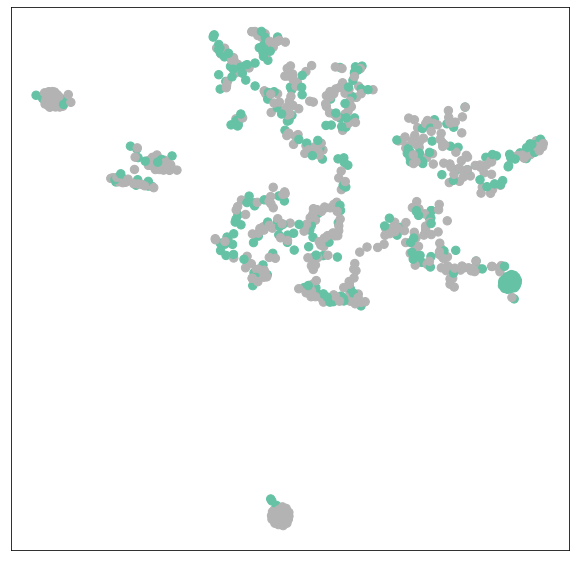

tensor([0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 0., 1., 1., 1., 0., 1., 1., 

In [5]:
# from torch_geometric.nn import GCNConv
# from torch.nn import Linear
# import torch.nn.functional as F
# import torch_geometric.data as tgd

# %matplotlib inline
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# gv_pyt=list(map(tgu.from_networkx, graphs_vec))
# batch_train=tgd.Batch.from_data_list(gv_pyt[0:24])
# batch_test=tgd.Batch.from_data_list(gv_pyt[24:35])

# #increase train period

# def visualize(h, color):
#     z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

#     plt.figure(figsize=(10,10))
#     plt.xticks([])
#     plt.yticks([])

#     plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
#     plt.show()

# class GCN(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super(GCN, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = GCNConv(batch_train.num_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, 2)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x



# model = GCN(hidden_channels=16)
# print(model)

# model = GCN(hidden_channels=16).double()
# model.eval()

# out = model(batch_train.x.double(), batch_train.edge_index)
# visualize(out, color=batch_train.y)
# batch_train.y

# Training and Testing the Models (Financial Only)





In [6]:
# from IPython.display import Javascript  # Restrict height of output cell.
# from sklearn.model_selection import ShuffleSplit
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# model = GCN(hidden_channels=16).double()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# criterion = torch.nn.CrossEntropyLoss()
# #smoothL1 loss if we go to regression loss. investigate other losses for classification
# #potential sigmoid layer as well

# def train():
#       model.train()
#       optimizer.zero_grad()  # Clear gradients.
#       out = model(batch_train.x.double(), batch_train.edge_index)  # Perform a single forward pass.
#       loss = criterion(out, batch_train.y.long())  # Compute the loss solely based on the training nodes.
#       loss.backward()  # Derive gradients.
#       optimizer.step()  # Update parameters based on gradients.
#       return loss

# def test():
#       model.eval()
#       out = model(batch_test.x.double(), batch_test.edge_index).double()
#       pred = out.argmax(dim=1)  # Use the class with highest probability.
#       test_correct = pred == batch_test.y.double()  # Check against ground-truth labels.
#       test_acc = int(test_correct.sum()) / len(batch_test.y)  # Derive ratio of correct predictions.
#       return test_acc

# for epoch in range(1, 201):
#     loss = train()
#     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.6946
Epoch: 002, Loss: 0.6894
Epoch: 003, Loss: 0.6848
Epoch: 004, Loss: 0.6800
Epoch: 005, Loss: 0.6764
Epoch: 006, Loss: 0.6732
Epoch: 007, Loss: 0.6693
Epoch: 008, Loss: 0.6677
Epoch: 009, Loss: 0.6629
Epoch: 010, Loss: 0.6647
Epoch: 011, Loss: 0.6639
Epoch: 012, Loss: 0.6640
Epoch: 013, Loss: 0.6662
Epoch: 014, Loss: 0.6621
Epoch: 015, Loss: 0.6581
Epoch: 016, Loss: 0.6624
Epoch: 017, Loss: 0.6606
Epoch: 018, Loss: 0.6626
Epoch: 019, Loss: 0.6592
Epoch: 020, Loss: 0.6605
Epoch: 021, Loss: 0.6579
Epoch: 022, Loss: 0.6609
Epoch: 023, Loss: 0.6552
Epoch: 024, Loss: 0.6579
Epoch: 025, Loss: 0.6533
Epoch: 026, Loss: 0.6551
Epoch: 027, Loss: 0.6551
Epoch: 028, Loss: 0.6577
Epoch: 029, Loss: 0.6511
Epoch: 030, Loss: 0.6526
Epoch: 031, Loss: 0.6509
Epoch: 032, Loss: 0.6523
Epoch: 033, Loss: 0.6503
Epoch: 034, Loss: 0.6507
Epoch: 035, Loss: 0.6504
Epoch: 036, Loss: 0.6509
Epoch: 037, Loss: 0.6486
Epoch: 038, Loss: 0.6441
Epoch: 039, Loss: 0.6432
Epoch: 040, Loss: 0.6438


# Running the Model (Financial Only)

In [7]:
# test_acc = test()
# print(f'Test Accuracy: {test_acc:.4f}')
#training the model cut the accuracy here
#next steps- potentially need to consider a different test/train split
#need other data in this graph- need to know how chronologically diverse the articles data is

#61.58%

#regular split- 64.22% went up, 35.78% went down
#prediction is not working well

# sum=0
# for label in batch_test.y:
#   if label==1:
#     sum=sum+1
#   else:
#     continue



Test Accuracy: 0.6158
